In [1]:
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!sh -e /etc/init.d/x11-common start
import os
os.putenv('DISPLAY', ':99.0')
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.4 MB 5.2 MB/s 
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvid

### Load score

In [7]:
# opus133 = corpus.parse('beethoven/opus133.mxl')
# opus133.show()
path = 'gdrive/My Drive/Colab Notebooks/Beethoven_String_Quartet/'
mxl_file2 = path+'String_Quartet_No._15_in_D_minor_K421.mxl'
k421 = converter.parse(mxl_file2, format='musicxml')
k421s = k421.measures(1,1)

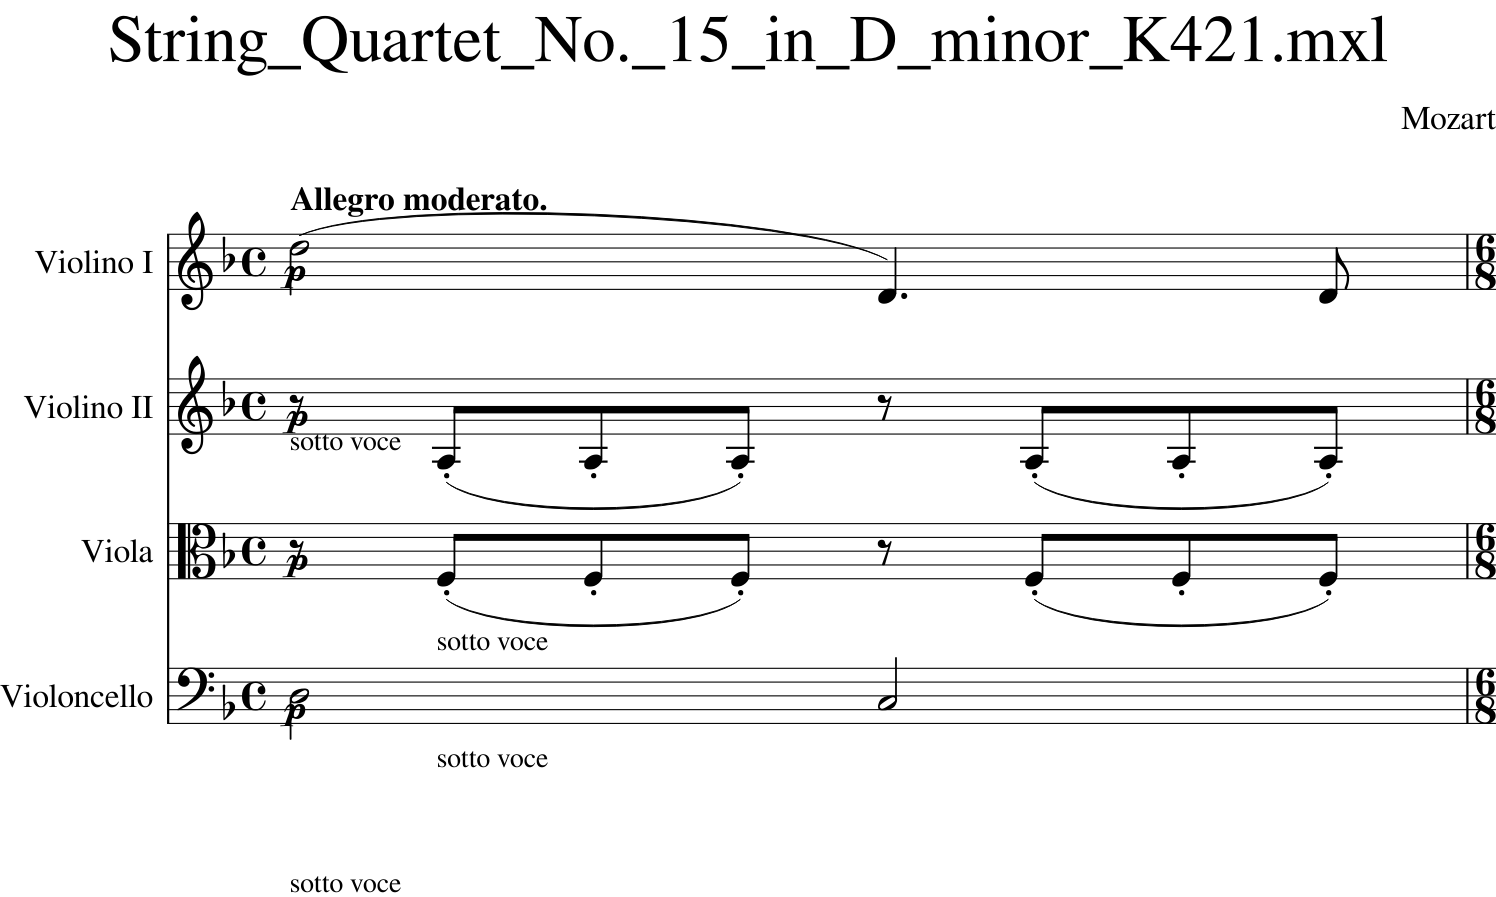

In [8]:
k421s.show()

### Functions



In [9]:
# Graph normalized cut

import networkx as nx
import numpy as np
import logging

def normalized_min_cut(graph):

    m_adjacency = np.array(nx.to_numpy_matrix(graph))

    D = np.diag(np.sum(m_adjacency, 0))
    D_half_inv = np.diag(1.0 / np.sqrt(np.sum(m_adjacency, 0)))
    M = np.dot(D_half_inv, np.dot((D - m_adjacency), D_half_inv))

    (w, v) = np.linalg.eig(M)
    #find index of second smallest eigenvalue
    index = np.argsort(w)[1]

    v_partition = v[:, index]
    v_partition = np.sign(v_partition)
    return v_partition

In [10]:
part_to_idx = {"Violino I":0, "Violino II":1, "Viola":2, "Violoncello":3}

def parse_verticality(score):
    scoreTree = tree.fromStream.asTimespans(score, flatten=True,
       classList=(note.Note, chord.Chord))
    
    return scoreTree

def add_node(scoreTree):
    G = nx.Graph()
    n_idx = 1
    break_flag = False
    
    for i, verticality in enumerate(scoreTree.iterateVerticalities()):
        if break_flag:  
            break
        else:         
            print(f"{i} verticality starts {verticality.offset} - ends {verticality.nextStartOffset}")
            if verticality.nextStartOffset-verticality.offset>=10:
                break_flag = True;
            # all the notes that just started in this verticality
            startedNotes = verticality.startTimespans
            print(startedNotes)
            for snote in startedNotes:
                part_idx = part_to_idx[snote.part.partName]
                G.add_nodes_from([(n_idx, {"note": snote, "start": snote.offset, "end":snote.endTime, "ver": i, "part": part_idx})])
                n_idx += 1        
            print('------------------')
            ver_len = i
    
    return G, ver_len

In [15]:
def add_horizontal_edge(G):
    for instrument in ["Violino I", "Violino II", "Viola", "Violoncello"]:
        notes_same_part = [x for x,y in G.nodes(data=True) if y['note'].part.partName==instrument]
        for i in range(len(notes_same_part)-1):
            w = assign_horizontal_weight(G.nodes[notes_same_part[i]]["note"], G.nodes[notes_same_part[i+1]]["note"])
            G.add_edge(notes_same_part[i], notes_same_part[i+1], weight=w)

    return G

def assign_horizontal_weight(u, v, h_reg=2.0, part_bias=0.2, slur_bias = 0.4):
    pitch1, pitch2 = u.element,v.element
    h_int = abs(float(interval.Interval(noteStart=pitch1, noteEnd=pitch2).cents)/100)
    if h_int == 0:
        return 1000
    else:
        if check_slur(u,v):
            return 1*h_reg/h_int+part_bias+slur_bias
        else:
            return 1*h_reg/h_int+part_bias


def check_slur(u,v):
    if u.element.getSpannerSites() == [] or v.element.getSpannerSites() == []:
        return True

def add_vertical_edge(G, ver_len):
    for ver in range(ver_len):
        notes_same_vert = [x for x,y in G.nodes(data=True) if y['ver']==ver]
        for i in range(len(notes_same_vert)-1):
            w = assign_vertical_weight(G.nodes[notes_same_vert[i]]["note"], G.nodes[notes_same_vert[i+1]]["note"])
            G.add_edge(notes_same_vert[i], notes_same_vert[i+1], weight=w)
    for i in range(len(G.nodes)):
        for j in range(len(G.nodes)):
            node1, node2 = G.nodes[i+1], G.nodes[j+1]
            if node1["start"] <= node2["start"] and node1["end"] >= node2["end"]:
                if abs(node1["part"]-node2["part"]==1):
                    print(i,j)
                    w = assign_vertical_weight(node1["note"], node2["note"])
                    G.add_edge(i, j, weight=w)

    return G

def assign_vertical_weight(u, v, h_reg=2.0, concur_bias = 0.4):
    pitch1, pitch2 = u.element,v.element
    h_int = abs(float(interval.Interval(noteStart=pitch1, noteEnd=pitch2).cents)/100)
    if h_int == 0:
        return 1000
    else:
        if h_int <= 6:
            return 1*h_reg/h_int + concur_bias
        else:
            return 1*h_reg/h_int

In [16]:
score = k421s

scoreTree = parse_verticality(score)
G = nx.Graph()
G, ver_len = add_node(scoreTree)
G = add_horizontal_edge(G)

0 verticality starts 0.0 - ends 0.5
(<PitchedTimespan (0.0 to 2.0) <music21.note.Note D>>, <PitchedTimespan (0.0 to 2.0) <music21.note.Note D>>)
------------------
1 verticality starts 0.5 - ends 1.0
(<PitchedTimespan (0.5 to 1.0) <music21.note.Note A>>, <PitchedTimespan (0.5 to 1.0) <music21.note.Note F>>)
------------------
2 verticality starts 1.0 - ends 1.5
(<PitchedTimespan (1.0 to 1.5) <music21.note.Note A>>, <PitchedTimespan (1.0 to 1.5) <music21.note.Note F>>)
------------------
3 verticality starts 1.5 - ends 2.0
(<PitchedTimespan (1.5 to 2.0) <music21.note.Note A>>, <PitchedTimespan (1.5 to 2.0) <music21.note.Note F>>)
------------------
4 verticality starts 2.0 - ends 2.5
(<PitchedTimespan (2.0 to 3.5) <music21.note.Note D>>, <PitchedTimespan (2.0 to 4.0) <music21.note.Note C>>)
------------------
5 verticality starts 2.5 - ends 3.0
(<PitchedTimespan (2.5 to 3.0) <music21.note.Note A>>, <PitchedTimespan (2.5 to 3.0) <music21.note.Note F>>)
------------------
6 verticality st

In [17]:
nx.info(G)

'Graph with 17 nodes and 13 edges'

In [18]:
G = add_vertical_edge(G, ver_len)

1 3
1 5
1 7
3 2
5 4
7 6
9 11
9 13
9 16
11 10
13 12
15 14
16 15


In [19]:
nx.info(G)

'Graph with 17 nodes and 33 edges'

In [20]:
v_partition = normalized_min_cut(G)

In [21]:
v_partition

array([-1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,  1., -1.,
        1., -1., -1.,  1.])